**The Leading Edge - Geophysical Tutorial (TLE April 2017)** :: http://dx.doi.org/10.1190/tle36040352.1

# Getting started with controlled-source electromagnetic 1D modeling

Dieter Werthmüller

*This Jupyter Notebook accompanies the Geophysical Tutorial from The Leading Edge April 2017 edition with the same title, see [github.com/seg/tutorials-2017](https://github.com/seg/tutorials-2017).*

**Note:** I changed the notebook slightly on 2018-03-27, removing the requirement of $\LaTeX$ for the annotations. The figure annotations might therefore look slightly different, but it lowers the requirement burden. If you prefer the $\LaTeX$-rendered version, just get the previous commit of this notebook.

## Electromagnetic modeling

Forward modeling is an important part of understanding controlled-source electromagnetic (CSEM) responses. The diffusive term in the electromagnetic wave equation is dominant over the displacement term at these frequencies. It is the diffusive behavior that makes it difficult to imagine the actual propagation of the signal. An important tool in gaining experience therefore is forward modeling, and lots of it. The advantage of one-dimensional (1D) forward modeling, besides its speed, is to study isolated effects (see for instance [Key, 2009](#References)): What is the influence of resistivity anisotropy, or of fine-scale resistivity variations? What is the influence of the airwave? With 1D modeling you can quickly study these effects in isolation before you go on to more complex models in higher dimensions. For an introduction to CSEM for hydrocarbon exploration see, for instance [Constable (2010)](#References).

Luckily the EM community can count on some freely available, stable, high-quality, and open-source CSEM modeling codes. Well-known ones are the codes from the Marine EM Lab at Scripps: `DIPOLE1D` ([Key, 2009](#References)) and `MARE2DEM` ([Key and Ovall, 2011](#References)) for 1D and 2D modeling. `DIPOLE1D` is an isotropic EM modeler for a stratified model using the diffusive approximation valid for low frequencies such as used in CSEM (neglecting displacement currents). `MARE2DEM` is a 2.5D CSEM and magnetotelluric (MT) modeling and inversion code, including resistivity anisotropy. More recently, [Cockett et al. (2015)](#References) published `SimPEG` , and [Hunziker et al. (2015)](#References) `EMmod` . `SimPEG` is a framework for 3D simulation and modeling of all sorts of geophysical methods, among them CSEM. `EMmod` is a 1D electromagnetic modeler including anisotropy in the form of vertical transverse isotropic (VTI) resistivity as well as VTI electric permittivity and VTI magnetic permeability, therefore modeling the whole wavefield for electric and magnetic sources and receivers.


## `empymod`

In this tutorial I use the 1D electromagnetic forward modeling code [empymod](https://empymod.github.io), which is based on:
    
- **[Hunziker et al. (2015)](#References)**, for the wavenumber-domain calculation of the EM field. The authors
  obtained the electromagnetic field by solving two equivalent scalar equations with a scalar
  global reflection coefficient, for a layered earth with vertical transverse isotropy (VTI).
- **[Key (2012)](#References)**, for the Hankel and Fourier transforms. Key compares the fast Hankel transform
  (FHT, e.g. [Anderson, 1979](References)) to quadrature-with-extrapolation (QWE), both are much faster than the
  Gauss-Kronrod quadrature used in `EMmod` by [Hunziker et al. (2015)](#References). Both methods can be applied
  for the Hankel and the Fourier transforms.

There are many ways to get `empymod`:

1. **Conda**:

        conda install -c prisae empymod
    
   If you are using the Anaconda Navigator, just add the channel `prisae` and empymod will appear in the package list.

2. **Pip**:

        pip install empymod
    
3. Download, clone, or fork on **GitHub**: [github.com/empymod/empymod](https://github.com/empymod/empymod).
   To install it run

        python setup.py install

   or simply put it in your working directory or Python-PATH to use it without installation at all.

Minimum requirement is Python 3.4 or higher, and `NumPy` and `SciPy`. The easiest way to meet all requirements if you are new to Python is to use the [Anaconda Python Distribution](https://www.continuum.io/downloads).

The electromagnetic python modeller `empymod` can model electric or magnetic responses due to a three-dimensional electric or magnetic source in a layered-earth model (Figure 1) with $n$ layers, each with electric vertical isotropy ($\rho_\text{h}$, $\lambda$), horizontal and vertical electric permittivity ($\epsilon_\text{h}$, $\epsilon_\text{v}$), and horizontal and vertical magnetic permeability ($\mu_\text{h}$, $\mu_\text{v}$), from very low frequencies ($f \to$ 0 Hz) to very high frequencies ($f \to$ GHz). The layer parameters all default to 1 if not provided ($\rho_\text{h}$ is mandatory).

---

<img src="./figures/model.png" width="400" alt="Figure 1" title="Figure 1">
<center>*Figure 1. A layered earth model. Each horizontal layer is parameterized by horizontal resistivity and anisotropy, horizontal and vertical magnetic permeability, and horizontal and vertical electric permittivity.*</center>

---


## 0. Preliminaries

In [1]:
# Load NumPy for array creation
import numpy as np

# Load the bipole-modeling routine from empymod
from empymod import bipole

# Load plotting library
import matplotlib as mpl
import matplotlib.pyplot as plt

# Plot settings to customize plots; you can happily ignore this
mpl.style.use('ggplot')
mpl.rcParams['font.size'] = 12
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.style'] = 'normal'

# This is important if you want interactive figures
%matplotlib notebook

## 1. A first example

We start with a simple model of a half-space below air:

-  air/half-space interface at $0\,$m;
-  electric, $x$-directed source at $x=0\,$m, $y=0\,$m, $z=1\,$m;
-  electric receiver at $x=1000\,$m, $y=0\,$m, $z=1\,$m, with azimuth $=45^\circ$ and dip $=10^\circ$; and
-  frequency of $2\,$Hz.

The function bipole takes up to 24 arguments, but 19 of those have default values. We only have to provide the five mandatory parameters for this simple example: sources, receivers, depths of the interfaces, resistivities, and frequencies:

In [2]:
inp1 = {'src': [0, 0, 1, 0, 0],
        'rec': [1000, 0, 1, 45, 10],
        'depth': 0,
        'res': [2e14, 100],
        'freqtime': 2}
bipole(**inp1)


:: empymod END; runtime = 0:00:00.006755 :: 3 kernel call(s)



array(2.20420889e-08-7.15386717e-10j)

From this example, you can infer that an infinitesimally small *dipole* is defined as $[x, y, z,$ azimuth, dip$]$, using a left-handed coordinate system with positive z pointing downward. The azimuth is the anti-clockwise deviation from the x-axis, and the dip is the deviation downward from the xy-plane. A finite length *bipole*, on the other hand, would be defined as $[x_1, x_2, y_1, y_2, z_1, z_2]$, where $[x_1, y_1, z_1]$ is the first pole location, and $[x_2, y_2, z_2]$ is the second pole location. We will see in the next example why the frequency parameter is called `freqtime`.

The default verbosity reveals that `empymod` took some milliseconds to run on my machine, and three kernel calls were required. This is because our receiver has an arbitrary rotation, so it had to calculate the x-, y-, and z-fields due to an x-directed source. And it returns a complex number, the result.

## 2. Simple example in frequency and time domain

We keep it simple in terms of source and receiver: An x-directed source with x-directed inline receivers for a 4-layer isotropic model (air, overburden, target, underburden), with and without hydrocarbons, as presented for instance in [Ziolkowski et al. (2007)](#References):

layer       | depth (m)      | resistivity ($\Omega\,$m) 
------------|----------------|--------------------
air         | $-\infty$ - 0  | 2e14                
overburden  | 0 - 500        | 20                  
target      | 500 - 525      | 20 (BG) or 500 (TG) 
underburden | 525 - $\infty$ | 20                  

In [3]:
# Collect the common input parameters
inp2 = {'src': [0, 0, 0.01, 0, 0],      # => Note: we have to put src-z and rec-z slightly below 0;
        'rec': [1000, 0, 0.01, 0, 0],   #          otherwise empymod would put them into the air-layer
        'depth': [0, 500, 525],         # Depth: all layer interfaces, without +/-infinity
        'verb': 0}                      # set verbosity to silent

# Define resistivities
brine = [2e14, 20, 20, 20]
oil = [2e14, 20, 500, 20]

# 1. Frequency domain
f = np.logspace(-1, 3, 100)                         # Define frequencies
brine_freq = bipole(res=brine, freqtime=f, **inp2)  # Calculate background
oil_freq = bipole(res=oil, freqtime=f, **inp2)      # Calculate target

# 2. Time domain (switch-on)
# To calculate time instead of frequency, we have to provide a signal:
# 0: impulse response; 1: switch-on; -1: switch-off
t = np.linspace(0, 0.06, 100)                                 # Define  times
brine_time = bipole(res=brine, freqtime=t, signal=1, **inp2)  # Calculate background
oil_time = bipole(res=oil, freqtime=t, signal=1, **inp2)      # Calculate target

### Figure

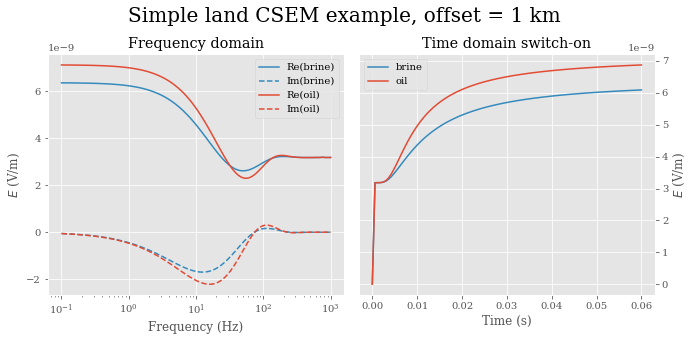

In [4]:
plt.figure(figsize=(9.8, 5), num='2. Simple example')
plt.subplots_adjust(left=0.08, right=.94, top=.82, bottom=.15, wspace=.05)
plt.suptitle('Simple land CSEM example, offset = 1 km', fontsize=20, y=.95)

# Plot frequency domain
plt.subplot(121)
plt.title('Frequency domain')
plt.semilogx(f, brine_freq.real, 'C1', label='Re(brine)')
plt.semilogx(f, brine_freq.imag, 'C1--', label='Im(brine)')
plt.semilogx(f, oil_freq.real, 'C0', label='Re(oil)')
plt.semilogx(f, oil_freq.imag, 'C0--', label='Im(oil)')
plt.xlabel('Frequency (Hz)')
plt.ylabel(r'$E$ (V/m)')
plt.legend()

# Plot time domain
ax2 = plt.subplot(122)
plt.title('Time domain switch-on')
plt.plot(t, brine_time, 'C1', label='brine')
plt.plot(t, oil_time, 'C0', label='oil')
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position('right')
plt.xlabel('Time (s)')
plt.ylabel(r'$E$ (V/m)')
plt.legend()

# Display
plt.show()


Figure 2 shows the comparison of frequency-domain and time-domain responses for the same model. The jump in the time-domain response is the so-called airwave; this is why the switch-on response is sometimes also called step-response. Now you see why the frequency-parameter is called `freqtime`: this parameter takes frequencies if `signal = None` (default) or times if `signal = {-1, 0, 1}`.

Next we have a look at the difference between a dipole and a bipole.


## 3. Bipole versus dipole
The modeler `empymod` can handle bipole sources and receivers of arbitrary length and direction
(where a bipole has a significant distance between the electrodes, as compared to a infinitesimally small dipole). So if you can model a bipole, why would you bother to check if you can model it as a dipole? The answer is speed. To model a bipole you integrate along the bipole by calculating various dipoles. If both source and receiver are bipoles, and you interpolate with 5 points each, you need 25 times longer to model the bipole-bipole survey instead of the simplified dipole-dipole survey.

I have a memory of a rule of thumb that says that if your offset is more than 5 times the bipole length you can model it as a dipole. I cannot remember where I got that rule from, but we check it with an example. For this we use the target-model of the previous example.

layer       | depth (m)      | resistivity ($\Omega\,$m) 
------------|----------------|--------------------
air         | $-\infty$ - 0  | 2e14                
overburden  | 0 - 500        | 20                  
target      | 500 - 525      | 500 
underburden | 525 - $\infty$ | 20             

We use x-directed receiver dipoles and

1. x-directed source dipole,
2. x-directed, 200 m long source bipole.

Bipoles are defined as $[x_1, x_2, y_1, y_2, z_1, z_2]$, where $[x_1, y_1, z_1]$ and $[x_2, y_2, z_2]$ are the two poles. The parameters `srcpts`/`recpts` define how many dipoles are calculated to model the bipole. If `srcpts`/`recpts` is smaller than 3, the bipoles are approximated by a dipole at its center location.

In [5]:
off3 = np.arange(100)*25+125  # Offsets

# Collect the common input parameters
inp3 = {'src': [-100, 100, 0, 0, 0.01, 0.01],  # Source => Bipoles are defined as: [x1, x2, y1, y2, z1, z2]
        'rec': [off3, np.zeros(off3.shape), 0.01, 0, 0],
        'depth': [0, 500, 525],
        'res': [2e14, 20, 500, 20],
        'freqtime': 1.0,
        'verb': 0}

# 1. As dipole: srcpts = 1
asdipole = bipole(srcpts=1, **inp3)

# 2. As bipole: integrate with 5 points
asbipole = bipole(srcpts=5, **inp3)

# 3. Calculate the error
error = np.abs((asdipole-asbipole)/asbipole)

### Figure

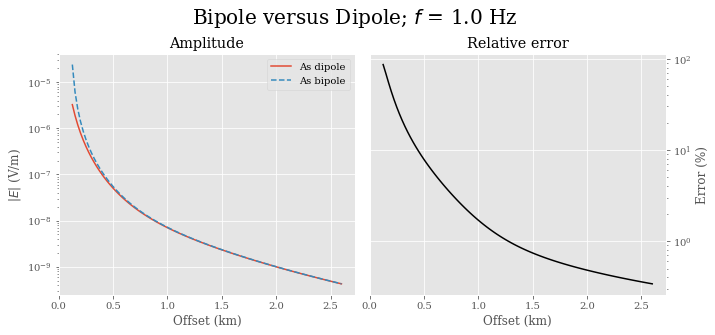

Source length = 200 m; 5x source length =  1000 m.
Error at:
          1.0 km = 1.7 %.
          1.275 km = 1.0 %.


In [6]:
plt.figure(figsize=(9.8, 5), num='3. Bipole versus dipole')
plt.subplots_adjust(left=0.08, right=.94, top=.82, bottom=.15, wspace=.05)
plt.suptitle(r'Bipole versus Dipole; $f$ = '+str(inp3['freqtime'])+' Hz', fontsize=20, y=.95)

# Plot Amplitude versus Offset
plt.subplot(121)
plt.title('Amplitude')
plt.semilogy(off3/1000, np.abs(asdipole), label='As dipole')
plt.semilogy(off3/1000, np.abs(asbipole), '--', label='As bipole')
plt.xlabel('Offset (km)')
plt.ylabel(r'$|E|$ (V/m)')
plt.legend()

# Plot Error versus Frequency
ax2 = plt.subplot(122)
plt.title('Relative error')
plt.semilogy(off3/1000, 100*error, 'k')
plt.xlabel('Offset (km)')
plt.ylabel(r'Error (%)')
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position('right')

# Display
plt.show()

# Let's print some errors
sl = inp3['src'][1] - inp3['src'][0]
print('Source length =', sl, 'm; 5x source length = ', 5*sl, 'm.')
print('Error at:')
for ir in [35, 46]:
    print('         ', off3[ir]/1000, 'km =', np.round(100*error[ir], 2), '%.')

At an offset of 5 times the source length the error is below 1.7 %, which might indeed be good enough, depending on the objective. Or you might want to go to offsets greater than ~1.3 km, so the error is below 1 %. This all depends of course on the model and the frequency.


## 4. Amplitude and phase of entire xy-plane

In the third example we calculate the EM-field in the entire xy-plane, as for instance in [Hunziker et al. (2015)](#References). Here we use a marine case with an electric, y-directed source and magnetic, x-directed receivers.

This time we define, as an example, all the parameters, with a very brief explanation. You can find a more extensive explanation of each parameter in the docstring by typing in `IPython` or in the Jupyter Notebook

    >>> bipole?

or in the documentation at [empymod.readthedocs.io](http://empymod.readthedocs.io/en/latest/empymod.html#empymod.model.bipole).

We use a simple, anisotropic marine model with a y-directed, electric source and x-directed, magnetic receivers:

layer       | depth (m)      | hor. resist. ($\Omega\,$m) | anisotropy (-)
------------|----------------|----------------------------|---------------
air         | $-\infty$ - 0  | 2e14                       | 1
water       | 0 - 300        | 0.3                        | 1
half-space  | 300 - $\infty$ | 1                          | 2

In [7]:
# Receivers: -0.5 km to 10 km; spacing of 10 meter => will yield a very dense, detailed EM field
x = (np.arange(1051))*10 - 500
rx = np.repeat([x,], np.size(x), axis=0)
ry = rx.transpose()
rrx = rx.ravel()  # Create flat arrays for input
rry = ry.ravel()

# Here we define for once ALL input parameters
# Generally you only have to define the parameters that you want to change from the default.
inp4 = {'src': [0, 0, 150, 90, 0],    # MANDATORY; y-direct source (azimuth=90) at depth=150 m
        'rec': [rrx, rry, 200, 0, 0], # MANDATORY; x-directed receivers at depth=200m
        'depth': [0, 300],            # MANDATORY; Layer interfaces depths
        'res': [2e14, 0.3, 1],        # MANDATORY; Resistivities
        'freqtime': 0.75,             # MANDATORY; Frequencies (or, if signal!=None, times)
        'signal': None,               # Default; None: freq-domain; {-1, 0, 1}: time domain
        'aniso': [1, 1, 2],           #          resistivity anisotropy [Default is None]
        'epermH': [1, 80, 10],        #          relative horizontal electric permittivity [Defaults is None]
        'epermV': [1, 80, 15],        #          relative vertical electric permittivity [Defaults is None]
        'mpermH': None,               # Default; relative horizontal magnetic permeability
        'mpermV': None,               # Default; relative vertical magnetic permeability
        'msrc': False,                # Default; electric source
        'srcpts': 1,                  # Default; if > 2, bipole sources are interpolated with srcpts
        'mrec': True,                 #          Magnetic receivers [Default is False]
        'recpts': 1,                  # Default; if > 2, bipole receivers are interpolated with recpts
        'strength': 0,                # Default; Src strength, the output is norm. to 1 m src, 1 m rec, 1 Am src strength
        'xdirect': True,              # Default; calculate the direct field analytically in the frequency domain
        'ht': 'fht',                  # Default; Use the Fast Hankel Transform method
        'htarg': None,                # Default; Use default arguments for FHT
        'ft': 'sin',                  # Default: Fourier transform method; unused as we model frequencies
        'ftarg': None,                # Default; Fourier transform arguments; unused as we model frequencies 
        'opt': 'spline',              #          Use the spline interpolation of the Filter method, default is None
        'loop': None,                 # Default; you can force it to loop over offsets ('off') or frequencies ('freq)
        'verb': 2}                    # Default; verbosity=2 prints warnings and runtime info

# Run the model and reshape the output
xyplane = bipole(**inp4)

# Reshape the output
xyplane = xyplane.reshape(np.shape(rx))

* WARNING :: Offsets < 0.001 m are set to 0.001 m!

:: empymod END; runtime = 0:00:01.040389 :: 1 kernel call(s)



We see from the warning (if `verb`>0) that the offset = 0 m was set to 0.001 m, to avoid division by zero. Minimum offset, minimum time, minimum frequency and other settings can be adjusted in `empymod.utils`, if need be. We also see that the calculation took less than 2 seconds for the 1051x1051 grid, hence over 1.1 millions offsets, thanks to the spline optimisation and the fact that the calculation in the wavenumber domain depends only on offset, not on angle. The angle factor is multiplied after the Hankel transform. The whole calculation can be done in one kernel call.

### Figure

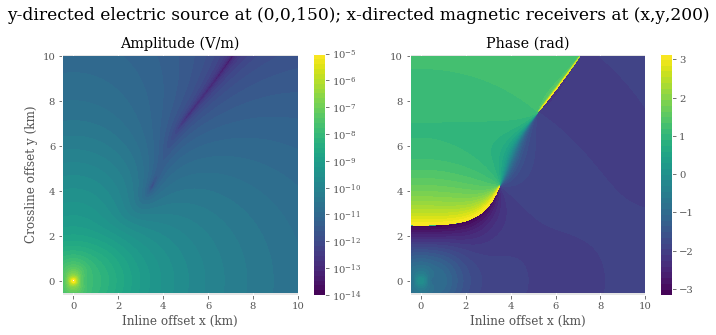

In [8]:
fig = plt.figure(figsize=(9.8, 5), num='4. Amplitude and phase of entire xy-plane')
plt.subplots_adjust(left=0.08, right=.99, top=.82, bottom=.15, wspace=.18)
plt.suptitle('y-directed electric source at (0,0,150); x-directed magnetic receivers at (x,y,200)', fontsize=17, y=.95)

# # # 1. Plot Amplitude # # # 
ax1 = plt.subplot(121)
plt.xlim(min(x)/1000, max(x)/1000)
plt.ylim(min(x)/1000, max(x)/1000)
plt.axis('equal')    

# Title and labels
plt.title('Amplitude (V/m)')
plt.ylabel('Crossline offset y (km)')
plt.xlabel('Inline offset x (km)')

# Draw filled contours and colorbar
cf1 = plt.contourf(rx/1000, ry/1000, np.abs(xyplane), levels=np.logspace(-14, -5, 50), locator=mpl.ticker.LogLocator())
cb1 = plt.colorbar(cf1, ticks=10.0**(-1*np.arange(5, 15)[::-1]))

# # # 2. Plot Phase # # #
ax2 = plt.subplot(122)
plt.xlim(min(x)/1000, max(x)/1000)
plt.ylim(min(x)/1000, max(x)/1000)
plt.axis('equal')

# Title and labels
plt.title('Phase (rad)')
plt.xlabel('Inline offset x (km)')

# Draw filled contours and colorbar
cf2 = plt.contourf(rx/1000, ry/1000, np.angle(xyplane), 50, vmin=-np.pi, vmax=np.pi)
cb2 = plt.colorbar(cf2, ticks=np.arange(7)-3)

# Display
plt.show()

Note that the result is symmetric about the source location (0,0), so you could mirror these quadrant to the other three quadrants.

## 5. Frequency-offset crossplot

In this example we plot (a) the amplitude of a target response and (b) the amplitude of the target response normalized by the background response, both as offset versus frequency. The first plot is useful to see for which frequencies and at which offsets we have a strong enough signal to be recorded (with the instruments at hand and given the expected noise level). The second plot then can be consulted to see if the target response at those frequencies and offsets is big enough for the model under consideration.

layer       | depth (m)       | hor. resist. ($\Omega\,$m) | anisotropy (-)
------------|-----------------|----------------------------|---------------
air         | $-\infty$ - 0   | 2e14                       | 1
water       | 0 - 300         | 0.3                        | 1
overburden  | 300 - 1000      | 1                          | 1.5
target      | 1000 - 1200     | 1 (BG) or 50 (TG)          | 1.5
underburden | 1200 - $\infty$ | 1                          | 1.5

In [9]:
off5 = np.arange(20, 101)*100  # Offsets

# Collect the common input parameters
inp5 = {'src': [0, 0, 250, 0, 0],
        'rec': [off5, np.zeros(81), 300, 0, 0],
        'depth': [0, 300, 1000, 1200],
        'freqtime': np.logspace(-1.5, .5, 33),  # 33 frequencies from 10**-1.5 to 10**0.5 (logspace)
        'aniso': [ 1, 1, 1.5, 1.5, 1.5],
        'verb': 0}

# Define resistivities
brine = [2e14, .3, 1, 1, 1]
oil = [2e14, .3, 1, 50, 1]

# Run the models
respbrn = bipole(res=brine, **inp5)
respoil = bipole(res=oil, **inp5)

# Get the exponents of the frequencies
lfreq = np.log10(inp5['freqtime'])

### Figure

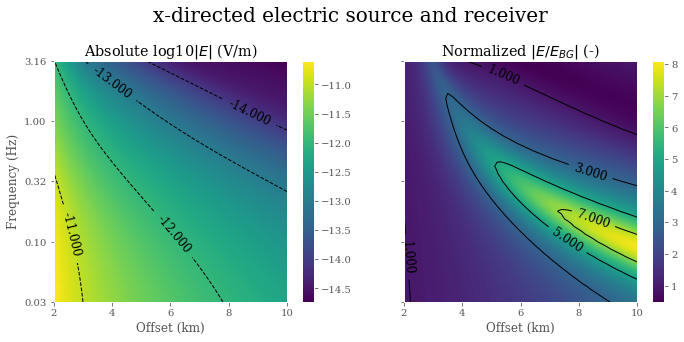

In [10]:
fig = plt.figure(figsize=(9.8, 5), num='5. Offset versus frequency')
plt.subplots_adjust(left=0.08, right=.99, top=.8, bottom=.13, wspace=.2)
plt.suptitle('x-directed electric source and receiver', fontsize=20, y=.95)

# # # 1. Plot amplitude # # #
ax1 = plt.subplot(121)

# Plotting it as imshow instead of contourf is much faster; however, you loose the discretization of the levels...
plt.imshow(np.log10(np.abs(respoil)), interpolation='bicubic',
           extent=[off5[0]/1000, off5[-1]/1000, lfreq[0], lfreq[-1]], origin='lower', aspect='auto')
plt.colorbar()
# Adding some contours
CS = plt.contour(off5/1000, lfreq, np.log10(np.abs(respoil)), [-14, -13, -12, -11], colors='k', linewidths=1)
plt.clabel(CS, inline=1, fontsize=12)

# Some figure settings (title, labels, etc)
plt.grid('off')
plt.title(r'Absolute log10$|E|$ (V/m)')
plt.ylim([lfreq[0], lfreq[-1]])
plt.xlim([off5[0]/1000, off5[-1]/1000])
plt.xlabel('Offset (km)')
plt.ylabel('Frequency (Hz)')
plt.yticks([-1.5, -1, -.5, 0, .5], ('0.03', '0.10', '0.32', '1.00', '3.16'))

# # # 2. Plot normalized response # # #
ax2 = plt.subplot(122)

# Plot result
plt.imshow(np.abs(respoil/respbrn), interpolation='bicubic',
           extent=[off5[0]/1000, off5[-1]/1000, lfreq[0], lfreq[-1]], origin='lower', aspect='auto')
plt.colorbar()
# Adding some contours
CS = plt.contour(off5/1000, lfreq, np.abs(respoil/respbrn), [1, 3, 5, 7], colors='k', linewidths=1)
plt.clabel(CS, inline=1, fontsize=12)

# Some figure settings (title, labels, etc)
plt.grid('off')
plt.title(r'Normalized $|E/E_{BG}|$ (-)')
plt.ylim([lfreq[0], lfreq[-1]])
plt.xlim([off5[0]/1000, off5[-1]/1000])
plt.xlabel('Offset (km)')
plt.yticks([-1.5, -1, -.5, 0, .5], ())

# Display
plt.show()

## 6. Anisotropy

Anisotropic CSEM modeling, more specifically vertical transverse isotropic (VTI) modeling, is the normal case these days (unlike 10 years ago). Resistivity anisotropy $\lambda$ and mean resistivity $\rho_\text{m}$ are commonly defined in terms of horizontal ($\rho_\text{h}$) and vertical ($\rho_\text{v}$) resistivity as

$$\lambda = \sqrt{\frac{\rho_\text{v}}{\rho_\text{h}}}\ , \qquad \text{and} \qquad \rho_\text{m} = \sqrt{\rho_\text{h}\rho_\text{v}} \ .$$

The three resistivities $\rho_\text{h}$, $\rho_\text{m}$, and $\rho_\text{v}$ are therefore related through $\lambda$,

$$\lambda\rho_\text{h} = \rho_\text{m} = \frac{1}{\lambda}\rho_\text{v} \ .$$

A common mistake is to only speak about *increasing anisotropy*, without further specification. As can be seen from the above relationship, *increasing anisotropy* is ambiguous.  The relationship between the three resistivities is elaborated in detail in [Werthmüller (2009)](#References), and presented in, e.g., [Hobbs et al. (2009)](#References). This is what we are going to explore in this example.

layer       | depth (m)       | hor. resist. ($\Omega\,$m) | anisotropy (-)
------------|-----------------|----------------------------|---------------
air         | $-\infty$ - 0   | 2e14                       | 1
half-space  | 0 - $\infty$    | variable                   | 1, 2, 3, or 4

In [11]:
# Define times
t6 =  np.linspace(0, 0.1, 100)
t6[0] = 0.0005  # Set a small starting time, slightly bigger than 0
# Collect input parameters
inp6 = {'src': [0, 0, 0.01, 0, 0],
        'rec': [2000, 0, 0.01, 0, 0],
        'depth': 0,
        'freqtime': t6,
        'signal': 1,
        'verb': 0}

# Isotropic case
res_isotr = bipole(res=[2e14, 20], aniso=[1, 1], **inp6)

# Keep horizontal resistivity constant
res_hor_2 = bipole(res=[2e14, 20], aniso=[1, 2], **inp6)
res_hor_3 = bipole(res=[2e14, 20], aniso=[1, 3], **inp6)
res_hor_4 = bipole(res=[2e14, 20], aniso=[1, 4], **inp6)

# Keep mean resistivity constant
res_mea_2 = bipole(res=[2e14, 20/2], aniso=[1, 2], **inp6)
res_mea_3 = bipole(res=[2e14, 20/3], aniso=[1, 3], **inp6)
res_mea_4 = bipole(res=[2e14, 20/4], aniso=[1, 4], **inp6)

# Keep vertical resistivity constant
res_ver_2 = bipole(res=[2e14, 20/2/2], aniso=[1, 2], **inp6)
res_ver_3 = bipole(res=[2e14, 20/3/3], aniso=[1, 3], **inp6)
res_ver_4 = bipole(res=[2e14, 20/4/4], aniso=[1, 4], **inp6)

### Figure

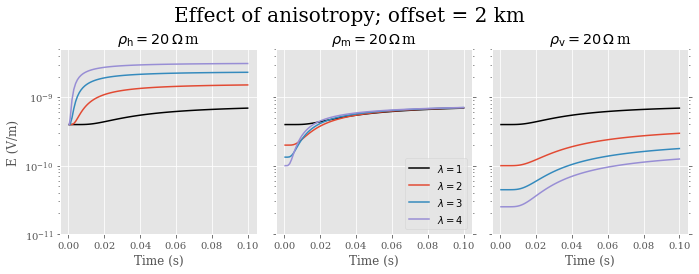

In [12]:
plt.figure(figsize=(9.8, 4), num='6. Anisotropy')
plt.subplots_adjust(left=0.09, right=.98, bottom=.16, top=.8, wspace=.1)
plt.suptitle('Effect of anisotropy; offset = 2 km', fontsize=20, y=.95)

# 1. Constant rho_h
plt.subplot(131)
plt.title(r'$\rho_{\rm{h}} = 20\,\Omega\,$m')
plt.semilogy(t6, res_isotr, 'k')
plt.plot(t6, res_hor_2, 'C0')
plt.plot(t6, res_hor_3, 'C1')
plt.plot(t6, res_hor_4, 'C2')
plt.xlabel('Time (s)')
plt.ylabel('E (V/m)')
plt.ylim(1e-11, 5e-9)

# 2. Constant rho_m
ax2 = plt.subplot(132)
plt.title(r'$\rho_{\rm{m}} = 20\,\Omega\,$m')
plt.semilogy(t6, res_isotr, 'k', label=r'$\lambda = 1$')
plt.plot(t6, res_mea_2, 'C0', label=r'$\lambda = 2$')
plt.plot(t6, res_mea_3, 'C1', label=r'$\lambda = 3$')
plt.plot(t6, res_mea_4, 'C2', label=r'$\lambda = 4$')
plt.xlabel('Time (s)')
ax2.set_yticklabels([])
ax2.yaxis.set_ticks_position('both')
plt.ylim(1e-11, 5e-9)
plt.legend(loc=4)

# 3. Constant rho_v
ax3 = plt.subplot(133)
plt.title(r'$\rho_{\rm{v}} = 20\,\Omega\,$m')
plt.semilogy(t6, res_isotr, 'k')
plt.plot(t6, res_ver_2, 'C0')
plt.plot(t6, res_ver_3, 'C1')
plt.plot(t6, res_ver_4, 'C2')
plt.xlabel('Time (s)')
ax3.set_yticklabels([])
ax3.yaxis.set_ticks_position('both')
plt.ylim(1e-11, 5e-9)

# Display
plt.show()

As can be seen from these results, stating *increasing anisotropy* can mean quite different things, and it is crucial to specify it more, for instance «increasing anisotropy by keeping the mean resistivity constant». The isotropic case, the black line, is the same in all three plots. The conclusions that can be drawn from the above results are:

1. The initial step, the airwave, depends only on horizontal resistivity.
2. The DC value, hence time $t\to\infty$, depends only on the mean resistivity.

These insights, which can be found as well by studying the analytical half-space solutions, can be used to calculate apparent anisotropy values of the subsurface from early and late time CSEM responses.


## 7. Common-source gather

This is an example that might appeal more to readers coming from tnhe seismic community, as its display is similar to seismic data: time-domain impulse responses, displayed as common-source gather in time (as for instance in [Ziolkowski et al., 2011](#Reference)).


layer       | depth (m)       | hor. resist. ($\Omega\,$m) | anisotropy (-)
------------|-----------------|----------------------------|---------------
air         | $-\infty$ - 0   | 2e14                       | 1
water       | 0 - 600         | 0.3                        | 1
overburden  | 600 - 1500      | 1                          | 2
target      | 1500 - 1600     | 1 (BG) or 50 (TG)          | 3
underburden | 1600 - $\infty$ | 1                          | 1

In [13]:
# Define offset and time, collect parameters
off7 = np.arange(1,21)*500
t =  np.linspace(0, 10, 200)
inp7 = {'src': [0, 0, 550, 0, 0],
        'rec': [off7, np.ones(off7.shape)*1000, 600, 0, 0],  # For once we do not keep source and receiver inline
        'depth': [0, 600, 1500, 1600],
        'freqtime': t,
        'signal': 0,
        'aniso': [1, 1, 2, 3, 1],
        'opt': 'spline',
        'verb': 0}

# Define resistivities
brine = [2e14, 0.3, 1, 1, 1]
oil = [2e14, 0.3, 1, 50, 1]

# Run the model
imp_brn = bipole(res=brine, **inp7)
imp_oil = bipole(res=oil, **inp7)

### Figure

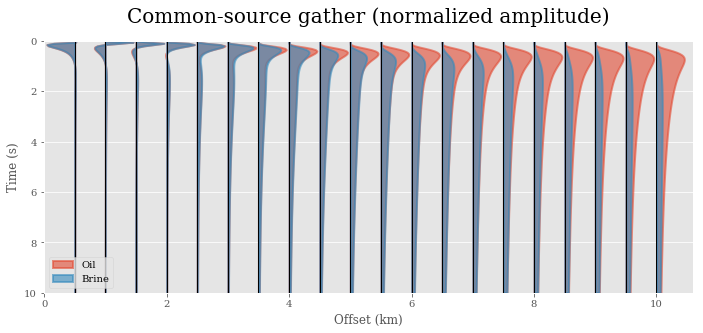

In [14]:
plt.figure(figsize=(9.8, 5), num='7. Common-source gather')
plt.subplots_adjust(left=0.07, right=.99, top=.85, bottom=.15, wspace=.05)
plt.title('Common-source gather (normalized amplitude)', fontsize=20, y=1.05)

# We loop over the offsets
for i, val in enumerate(off7/1000):
    # Get absolute max value of {brine, target} for this offset for normalization
    maxval = max(np.abs(imp_brn[:, i]).max(), np.abs(imp_oil[:, i]).max())
    
    # We will later divide the response by maxval, which will scale the maximum value to 1. In the plot we have an
    # offset at each 0.5 km => we double the maxval, to get to a maximum value of 0.5. Actually, we do a bit more
    # than double, to get the max amp a bit smaller than the spacing.
    maxval *= 2.2
    
    # (a) Plot vertical black line at offset
    plt.plot([val, val], [t.min(), t.max()], 'k', lw=1)
    
    # Shared fill arguments
    fbtwn = {'y': t, 'x2': val, 'alpha': 0.6, 'lw': 2}

    # (b) Target amplitude
    plt.fill_betweenx(x1=imp_oil[:, i]/maxval + val, color='C0', **fbtwn, label="Oil" if i == 0 else "")
    
    # (c) Background amplitude
    plt.fill_betweenx(x1=imp_brn[:, i]/maxval + val, color='C1', **fbtwn, label="Brine" if i == 0 else "")
    
# General figure settings
plt.legend(loc=3)
plt.ylabel('Time (s)')
plt.xlabel('Offset (km)')
plt.ylim([t.max(), t.min()])
plt.xlim([0, 10.6])

# Display
plt.show()

## 8. Interactive modeling

Jupyter and the ipywidgets make it incredibly easy to create interactive plots, which we use here to create an interactive model for `empymod`. All we need to do is to load the widgets, define our desired sliders, create a plot function as we have done before, and subsequently call `interact`.

Our model looks like this,

layer       | depth (m)                        | resistivity ($\Omega\,$m)
------------|----------------------------------|---------------------
air         | $-\infty$ - 0                    | 2e14
water       | 0 - 300                          | 0.3
overburden  | 300 - `depth`                    | 1
target      | `depth` - (`depth`+`thickness`)  | 1 (BG) or `resistivity` (TG)
underburden | (`depth`+`thickness`) - $\infty$ | 1

where we will implement  three sliders:

1. `resistivity` of the target layer ($\Omega\ $m)
2. `thickness` of the target layer (m)
3. Absolute `depth` from sea surface to the top of the target layer (m)

The following four lines import the required functions and define the three sliders:

In [15]:
from ipywidgets import FloatSlider, interact
w_res = FloatSlider(min=0.1, max=100.0, step=0.1, value=50, continuous_update=False)  # Target resistivity
w_thi = FloatSlider(min=10, max=500, step=10, value=200, continuous_update=False)     # Target thickness
w_dep = FloatSlider(min=350, max=3000, step=50, value=600, continuous_update=False)   # Target depth

In [16]:
# Acquisition parameters
off8 = np.arange(1, 201)*50                          # Offsets (m)
inp8 = {'freqtime': 0.5,                                 # Frequency (Hz)
        'src': [0, 0, 250, 0, 0],                        # Source dipole [x=0, y=0, z=250, azimuth=0, dip=0]
        'rec': [off8, np.zeros(off8.shape), 300, 0, 0],  # Receiver dipoles [x=off, y=0, z=300; azimuth=0, dip=0]
        'opt': 'spline'}

# Define background model
bg_dep = [0, 300]        # Air/Water interface at 0 m, water depth 300 m
bg_res = [2e14, 0.3, 1]  # Background of 1 Ohm m

# Calculate background model; for once we set verbosity high, so we see the output from `empymod` with all
# model, survey, and calculation parameters
bg_em = bipole(depth=bg_dep, res=bg_res, verb=3, **inp8)


:: empymod START  ::

   depth       [m] :  0 300
   res     [Ohm.m] :  2E+14 0.3 1
   aniso       [-] :  1 1 1
   epermH      [-] :  1 1 1
   epermV      [-] :  1 1 1
   mpermH      [-] :  1 1 1
   mpermV      [-] :  1 1 1
   frequency  [Hz] :  0.5
   Hankel          :  DLF (Fast Hankel Transform)
     > Filter      :  Key 201 (2009)
     > pts_per_dec :  Defined by filter (lagged)
   Hankel Opt.     :  Use spline
   Loop over       :  Frequencies
   Source(s)       :  1 dipole(s)
     > x       [m] :  0
     > y       [m] :  0
     > z       [m] :  250
     > azimuth [°] :  0
     > dip     [°] :  0
   Receiver(s)     :  200 dipole(s)
     > x       [m] :  50 - 10000 : 200  [min-max; #]
     > y       [m] :  0 - 0 : 200  [min-max; #]
     > z       [m] :  300
     > azimuth [°] :  0
     > dip     [°] :  0
   Required ab's   :  11

:: empymod END; runtime = 0:00:00.004351 :: 1 kernel call(s)



### Figure
Here we first plot the initial model, and then define the plotting routine which we will call afterwards with `interact` to update the figure:

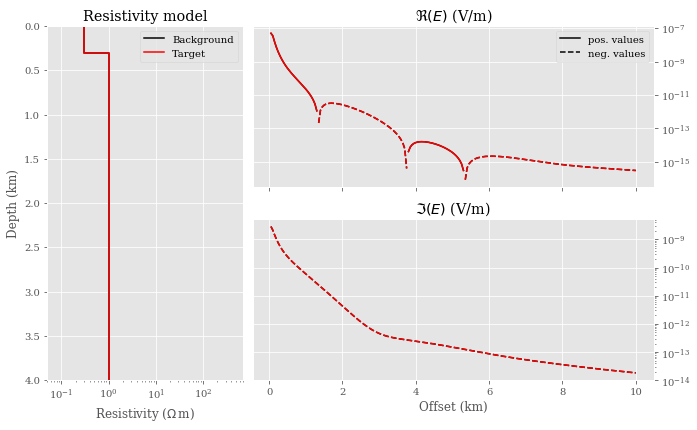

In [17]:
fig = plt.figure(figsize=(9.8, 6), num='8. Interactive modeling with empymod')
plt.subplots_adjust(left=0.07, right=.93, bottom=0.1, top=.92, wspace=.05)

# 1. Plot resistivity model; initialize target with background
ax1 = plt.subplot2grid((2, 3), (0, 0), rowspan=2)
ax1.set_title('Resistivity model')
bgres = np.r_[bg_res[1], bg_res[1:], bg_res[2]]
bgdep = np.r_[bg_dep, bg_dep[1], 4000]/1000
ax1.semilogx(bgres, bgdep, 'k', label='Background')
ax1.semilogx(bgres, bgdep, 'r', label='Target')
ax1.set_xlim([.05, 700])
ax1.set_ylim([4, 0])
ax1.legend()
ax1.set_ylabel('Depth (km)')
ax1.set_xlabel(r'Resistivity ($\Omega\,$m)')

# 2. Plot real part; initialize target with background
ax2 = plt.subplot2grid((2, 3), (0, 1), colspan=2)
ax2.semilogy(off8/1000, np.where(bg_em.real >= 0, bg_em.real, np.nan), 'k', label='pos. values')
ax2.semilogy(off8/1000, np.where(bg_em.real < 0, -bg_em.real, np.nan), 'k--', label='neg. values')
ax2.semilogy(off8/1000, np.where(bg_em.real >= 0, bg_em.real, np.nan), 'r')    # Positive values with solid line
ax2.semilogy(off8/1000, np.where(bg_em.real < 0, -bg_em.real, np.nan), 'r--')  # Negative values with dashed line
ax2.set_title(r'$\Re(E)$ (V/m)')
ax2.set_xticklabels([])
ax2.yaxis.tick_right()
ax2.legend()

# 3. Plot imaginary part; initialize target with background
ax3 = plt.subplot2grid((2, 3), (1, 1), colspan=2)
ax3.semilogy(off8/1000, np.where(bg_em.imag >= 0, bg_em.imag, np.nan), 'k')
ax3.semilogy(off8/1000, np.where(bg_em.imag < 0, -bg_em.imag, np.nan), 'k--')
ax3.semilogy(off8/1000, np.where(bg_em.imag >= 0, bg_em.imag, np.nan), 'r')
ax3.semilogy(off8/1000, np.where(bg_em.imag < 0, -bg_em.imag, np.nan), 'r--')
ax3.set_title(r'$\Im(E)$ (V/m)')
ax3.set_xlabel('Offset (km)')
ax3.yaxis.tick_right()

# 4. Define function in which we update the target response
def calc_em(resistivity, abs_depth, thickness):
    # Update target depth and resistivity with input
    tg_dep = np.r_[bg_dep, abs_depth, abs_depth + thickness]
    tg_res = np.r_[bg_res, resistivity, bg_res[2]]
    
    # Re-calculate the response
    tg_em = bipole(depth=tg_dep, res=tg_res, verb=0, **inp8)

    # Update model and response in plot
    ax1.lines[1].set_xdata([bg_res[2], resistivity, resistivity, bg_res[2]])
    ax1.lines[1].set_ydata(np.r_[abs_depth, abs_depth, abs_depth + thickness, abs_depth + thickness]/1000)
    ax2.lines[2].set_ydata(np.where(tg_em.real >= 0, tg_em.real, np.nan))  # Positive values with solid line
    ax2.lines[3].set_ydata(np.where(tg_em.real < 0, -tg_em.real, np.nan))  # Negative values with dashed line
    ax3.lines[2].set_ydata(np.where(tg_em.imag >= 0, tg_em.imag, np.nan))
    ax3.lines[3].set_ydata(np.where(tg_em.imag < 0, -tg_em.imag, np.nan))

In [18]:
fwgt = interact(calc_em, resistivity=w_res, abs_depth=w_dep, thickness=w_thi)

interactive(children=(FloatSlider(value=50.0, continuous_update=False, description='resistivity', min=0.1), FloatSlider(value=600.0, continuous_update=False, description='abs_depth', max=3000.0, min=350.0, step=50.0), FloatSlider(value=200.0, continuous_update=False, description='thickness', max=500.0, min=10.0, step=10.0), Output()), _dom_classes=('widget-interact',))

This interactive example should give you a good idea how to write your own interactive modeler. With a few changes you could instead have a slider for frequencies, anisotropies, source/receiver azimuth and dip, or any other parameter that goes into `bipole`.

## Final note

These eight examples should get you up and running with CSEM modeling in no time. You can find more notebooks on the `empymod`-site on GitHub under [/notebooks](https://github.com/prisae/empymod/tree/master/notebooks).

*Last but not least, if you are interested in this please get involved! I am open for suggestions and pull requests, thankful for bug reports, and happy if I see that you fork it and create something awesome of your own.*

Happy EM modeling!

## Appendix: Model discretization
Create figure of model discretization as used in introduction.

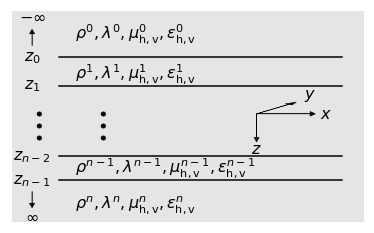

In [19]:
plt.figure(figsize=(5, 3), num='0. Model discretization')
plt.subplots_adjust(left=0.01, right=0.99, top=0.99, bottom=0.01)

# Some settings
text_prop = {'horizontalalignment': 'center', 'verticalalignment': 'center', 'fontsize': 16}
arrow_prop = {'fc': 'k', 'ec': 'k'}

# Plot x/y/z-coordinate system
x = 2
y = 1.4
# x
plt.text(x+.65, y, r'$x$', **text_prop)
plt.arrow(x, y, .5, 0, head_width=0.2, head_length=0.05, **arrow_prop)
# y
plt.text(x+.5, y-0.8, r'$y$', **text_prop)
plt.arrow(x, y, .3, -.4, head_width=0.08, head_length=0.12, **arrow_prop)
# z
plt.text(x, y+1.5, r'$z$', **text_prop)
plt.arrow(x, y, 0, 1, head_width=0.05, head_length=0.2, **arrow_prop)

# Plot arrows to +/- infinity
# -infinity
plt.text(-.1, -2.7, r'$-\infty$', **text_prop)
plt.arrow(-.1, -1.5, 0, -.5, head_width=0.05, head_length=0.2, **arrow_prop)
# +infinity
plt.text(-.1, 5.8, r'$\infty$', **text_prop)
plt.arrow(-.1, 4.7, 0, .5, head_width=0.05, head_length=0.2, **arrow_prop)

# Define layers
z = [-1, .2, 3.2, 4.2]
n = ['0', '1', '{n-2}', '{n-1}']
z2 = [-2, -.3, 3.7, 5.2]
n2 = ['0', '1', '{n-1}', 'n']

# Plot interfaces
for i, zn in enumerate(z):
    plt.plot([.15, 2.8], [zn, zn], 'k')
    plt.text(-.1, zn, r'$z_'+n[i]+'$', **text_prop)

# Plot layer parameters
for i, zn in enumerate(z2):
    ni = n2[i]
    plt.text(0.3, zn+.2,
             r'$\rho^'+ni+r', \lambda^'+ni+
             r', \mu_{\rm{h, v}}^'+ni+
             r', \epsilon_{\rm{h, v}}^'+ni+'$',
             fontsize=text_prop['fontsize'])
    
# Plot dots in middle layer
for i in range(3):
    plt.text(.5, 1.5+.5*i, '.', fontsize=40)
    plt.text(-.1, 1.5+.5*i, '.', fontsize=40)

# General plot settings
plt.grid('off')
plt.xticks([])
plt.yticks([])
plt.xlim([-.3, 3])
plt.ylim([6, -3])

# Display
plt.show()

## References

**Cockett, R., S. Kang, L. J. Heagy, A. Pidlisecky, and D. W. Oldenburg, 2015**, SimPEG: An open source framework for simulation and gradient based parameter estimation in geophysical applications: Computers & Geosciences, 142-154.  
DOI: [10.1016/j.cageo.2015.09.015](http://dx.doi.org/10.1016/j.cageo.2015.09.015)  
Software: [simpeg.xyz/](http://simpeg.xyz)
   
**Anderson, W. L., 1979**, Numerical integration of related Hankel transforms of orders 0 and 1 by adaptive digital filtering: Geophysics, 44, 1287-1305.  
DOI: [10.1190/1.1441007](http://dx.doi.org/10.1190/1.1441007)

**Hobbs, B. A., D. Werthmüller, and F. Engelmark, 2009**, Apparent anisotropy derived from transient electromagnetic earth responses: SEG Technical Program Expanded Abstracts, 744-748.  
DOI: [10.1190/1.3255861](http://dx.doi.org/10.1190/1.3255861)

**Hunziker, J., J. Thorbecke, and E. Slob, 2015**, The electromagnetic response in a layered vertical transverse isotropic medium: A new look at an old problem: Geophysics, 80, F1-F18.  
DOI: [10.1190/geo2013-0411.1](http://dx.doi.org/10.1190/geo2013-0411.1)  
Software: [software.seg.org/2015/0001](http://software.seg.org/2015/0001)
   
**Key, K., 2009**, 1D inversion of multicomponent, multifrequency marine CSEM data: Methodology and synthetic studies for resolving thin resistive layers: Geophysics, 74, F9-F20.  
DOI: [10.1190/1.3058434](http://dx.doi.org/10.1190/1.3058434)  
Software: [marineemlab.ucsd.edu/Projects/Occam/1DCSEM](http://marineemlab.ucsd.edu/Projects/Occam/1DCSEM)

**Key, K., and J. Ovall, 2011**, A parallel goal-oriented adaptive finite element method for 2.5-D electromagnetic modelling: Geophysical Journal International, 186, 137-154.  
DOI: [10.1111/j.1365-246X.2011.05025.x](http://dx.doi.org/10.1111/j.1365-246X.2011.05025.x)  
Software: [mare2dem.ucsd.edu](http://mare2dem.ucsd.edu)

**Key, K., 2012**, Is the fast Hankel transform faster than quadrature?: Geophysics, 77, F21-F30.  
DOI: [10.1190/GEO2011-0237.1](http://dx.doi.org/10.1190/GEO2011-0237.1)  
Software: [software.seg.org/2012/0003](http://software.seg.org/2012/0003)

**Werthmüller, D., 2009**, Inversion of Multi-Transient EM data from anisotropic media: M.Sc. Thesis.  
UUID: [f4b071c1-8e55-4ec5-86c6-a2d54c3eda5a](http://repository.tudelft.nl/view/ir/uuid:f4b071c1-8e55-4ec5-86c6-a2d54c3eda5a)

**Ziolkowski, A., B. A. Hobbs, and D. Wright, 2007**, Multitransient electromagnetic demonstration survey in France: Geophysics, 72, F197-F209.  
DOI: [10.1190/1.2735802](http://dx.doi.org/10.1190/1.2735802)

**Ziolkowski, A., D. Wright, and J. Mattsson, 2011**, Comparison of pseudo-random binary sequence and square-wave transient controlled-source electromagnetic data over the Peon gas discovery, Norway: Geophysical Prospecting, 59, 1114-1131.  
DOI: [10.1111/j.1365-2478.2011.01006.x](http://dx.doi.org/10.1111/j.1365-2478.2011.01006.x)

![CC-BY-SA](http://mirrors.creativecommons.org/presskit/buttons/88x31/png/by-sa.png)

&copy; Dieter Werthmüller. Final article published by the Society of Exploration Geophysicists in **The Leading Edge**, April 2017.

Citation:  
Werthmüller, D., 2017, Getting started with controlled-source electromagnetic 1D modeling: The Leading Edge, 36, 352-355;
doi: [10.1190/tle36040352.1](http://dx.doi.org/10.1190/tle36040352.1).